In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('../code')
import dataframe_utilities as util

In [4]:
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials
from functools import partial

# Get Data

In [5]:
df = pd.read_csv('../data/df_w_features.csv', low_memory=False)
df.shape

(24063, 599)

In [6]:
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

In [7]:
X_train = X[:-300]
y_train = y[:-300]
X_valid = X[-300:]
y_valid = y[-300:]

In [8]:
cats = [x for x in X.columns if X[x].dtype=='object']
encoder = ce.CatBoostEncoder(cols=cats, random_state=13)
# encoder = ce.TargetEncoder(cols=cats)
X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)
cats

['home_team_abbr',
 'away_team_abbr',
 'home_pitcher',
 'away_pitcher',
 'home_team_season',
 'away_team_season']

# Quick Look

In [9]:
xgb_params = {'colsample_bytree': 0.9,
     'learning_rate': 0.1,
     'max_depth': 27,
     'min_child_weight': 15.0,
     'reg_alpha': 6.73874,
     'subsample': 0.30}

In [10]:
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-error:0.444388	validation_1-error:0.443333
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 15 rounds.
[1]	validation_0-error:0.417834	validation_1-error:0.403333
[2]	validation_0-error:0.402685	validation_1-error:0.383333
[3]	validation_0-error:0.389387	validation_1-error:0.386667
[4]	validation_0-error:0.38379	validation_1-error:0.386667
[5]	validation_0-error:0.378445	validation_1-error:0.383333
[6]	validation_0-error:0.374995	validation_1-error:0.39
[7]	validation_0-error:0.372344	validation_1-error:0.396667
[8]	validation_0-error:0.366999	validation_1-error:0.393333
[9]	validation_0-error:0.361991	validation_1-error:0.4
[10]	validation_0-error:0.357194	validation_1-error:0.4
[11]	validation_0-error:0.35227	validation_1-error:0.393333
[12]	validation_0-error:0.351723	validation_1-error:0.376667
[13]	validation_0-error:0.347978	validation_1-error:0.38
[14]	validation

(0.6233333333333333, 0.6121650782233412)

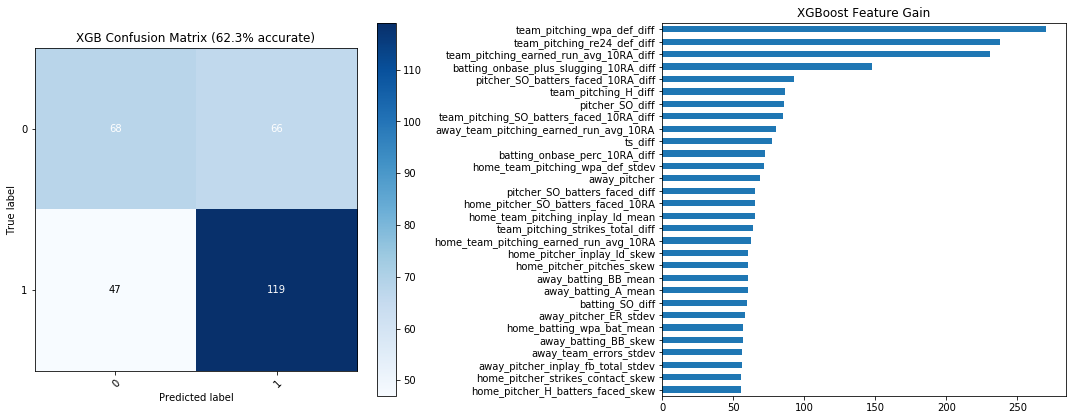

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], ax=ax[0], 
                           title = f"XGB Confusion Matrix ({accuracy_score(y_valid, xgb_test_preds)*100:.1f}% accurate)")

fig.tight_layout()

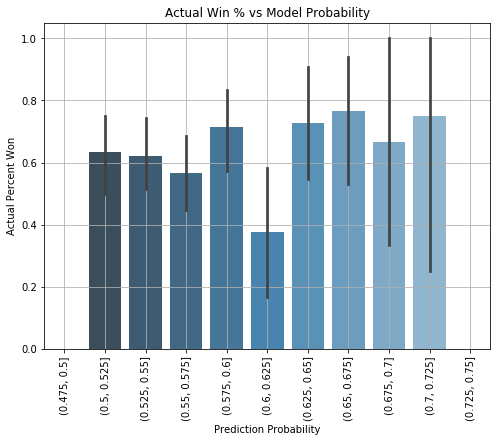

,mean,count
probability_bin,,
"(0.475, 0.5]",NaN,0
"(0.5, 0.525]",0.634615,52
"(0.525, 0.55]",0.621212,66
"(0.55, 0.575]",0.567164,67
"(0.575, 0.6]",0.714286,42
"(0.6, 0.625]",0.375000,24
"(0.625, 0.65]",0.727273,22
"(0.65, 0.675]",0.764706,17
"(0.675, 0.7]",0.666667,6


In [12]:
import seaborn as sns

df = pd.DataFrame()
df['proba'] = xgb_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df['bet_win'][df['proba']<.5] = -df['home_win']

bins=[x/40 for x in range(19,31)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

df.groupby('probability_bin')['bet_win'].agg(['mean','count'])

In [18]:
print("win % for bets with greater than x confidence:")
for x in range(10,18):
    x = x/20
    print(f" conf: {x:.2f}, win %:{df.bet_win[df.confidence>x].mean()*100:.1f}%")

win % for bets with greater than x confidence:
 conf: 0.50, win %:62.3%
 conf: 0.55, win %:62.1%
 conf: 0.60, win %:61.6%
 conf: 0.65, win %:74.1%
 conf: 0.70, win %:75.0%
 conf: 0.75, win %:nan%
 conf: 0.80, win %:nan%
 conf: 0.85, win %:nan%


In [ ]:
# import pickle
# pickle.dump((encoder, model), open('../data/encoder_model.pk','wb'))

# Hyperopt

In [12]:
def xgb_objective(params, data):
    params['max_depth']=int(params['max_depth'])
    
    np.random.seed(13)
    X_train,y_train,X_valid,y_valid = data
    gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    xgb_test_preds = model.predict(X_valid)
    return(-roc_auc_score(y_valid, xgb_test_preds))
    
def get_xgbparams(X,y):
    # find hyperparaams
    space = {
        'max_depth':  hp.quniform('max_depth', 10, 30, 1),
        'min_child_weight': hp.quniform('min_child_weight', 2, 20, 1),
        'subsample': hp.quniform('subsample', 0.05, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.05, 1, 0.05),
        'reg_alpha': hp.qloguniform('reg_alpha', -4, 5, 1e-5),
        'learning_rate': hp.qloguniform('learning_rate', -4, -0.5, 1e-2),
    }
    trials = Trials()
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials)
    return params

In [13]:
xgb_params = get_xgbparams(X_train,y_train)
xgb_params['max_depth']=int(xgb_params['max_depth'])
xgb_params

100%|██████████| 50/50 [28:14<00:00, 35.58s/it, best loss: -0.6583797878079481]


{'colsample_bytree': 0.65,
 'learning_rate': 0.3,
 'max_depth': 26,
 'min_child_weight': 18.0,
 'reg_alpha': 0.057490000000000006,
 'subsample': 0.6000000000000001}

# Model

In [14]:
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=13)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-error:0.387451	validation_1-error:0.41
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 15 rounds.
[1]	validation_0-error:0.352439	validation_1-error:0.383333
[2]	validation_0-error:0.329209	validation_1-error:0.38
[3]	validation_0-error:0.312376	validation_1-error:0.363333
[4]	validation_0-error:0.296175	validation_1-error:0.336667
[5]	validation_0-error:0.280394	validation_1-error:0.366667
[6]	validation_0-error:0.26718	validation_1-error:0.376667
[7]	validation_0-error:0.256912	validation_1-error:0.373333
[8]	validation_0-error:0.244161	validation_1-error:0.39
[9]	validation_0-error:0.230989	validation_1-error:0.38
[10]	validation_0-error:0.219964	validation_1-error:0.39
[11]	validation_0-error:0.209065	validation_1-error:0.403333
[12]	validation_0-error:0.197997	validation_1-error:0.386667
[13]	validation_0-error:0.191095	validation_1-error:0.39
[14]	validation_0-er

(0.6633333333333333, 0.6583797878079481)

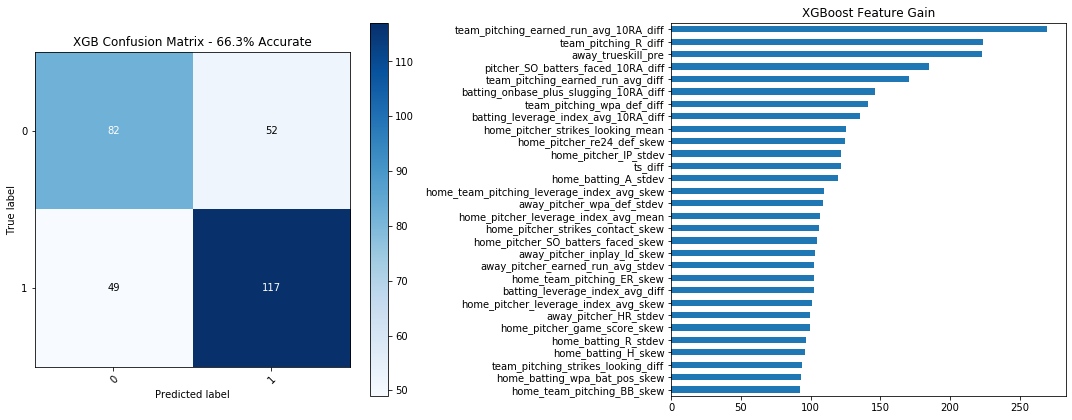

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = f"XGB Confusion Matrix - {accuracy_score(y_valid, xgb_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

In [16]:
# import pickle
# pickle.dump((encoder, model), open('../data/encoder_model.pk','wb'))

# Other Models

## LightGBM

In [ ]:
import lightgbm as lgbm

In [ ]:
gbm = lgbm.LGBMClassifier(num_boost_round=100, random_state=-1)
model = gbm.fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = model.predict(X_valid)
lgbm_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
def lgbm_objective(params, data):
    X_train,y_train,X_valid,y_valid = data
    params['num_leaves']=int(params['num_leaves'])
    params['min_child_samples']=int(params['min_child_samples'])
    params['max_bin']=int(params['max_bin'])
    params['bagging_freq']=int(params['bagging_freq'])
    
    np.random.seed(13)
    gbm = lgbm.LGBMClassifier(**params, num_boost_round=100, random_state=13)
    lgbm_model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    lgbm_test_preds = lgbm_model.predict(X_valid)
    return -roc_auc_score(y_valid,lgbm_test_preds)

def get_lgbmparams(X_train,y_train,X_valid,y_valid):
    # find hyperparaams
    space = {
        'boosting_type': hp.choice('boosting_type', ['gbdt','dart']),
        'subsample': hp.quniform('subsample', 0.5, 1, .05),
        'num_leaves': hp.quniform('num_leaves', 5, 150, 1),
        'learning_rate': hp.qloguniform('learning_rate', -4, -0.5, 1e-2),
        'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
        'reg_alpha': hp.quniform('reg_alpha', 0.0, 1.0,.05),
        'reg_lambda': hp.quniform('reg_lambda', 0.0, 1.0,.05),
        'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0,.05),
        'bagging_freq': hp.quniform ('bagging_freq', 1, 5, 1),
        'max_bin': hp.quniform ('max_bin', 64, 512, 1)
    }
    trials = Trials()
    fmin_objective = partial(lgbm_objective, data=(X_train,y_train,X_valid,y_valid))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials)
    return params

In [ ]:
lgbm_params = get_lgbmparams(X_train,y_train,X_valid,y_valid)

In [ ]:
if lgbm_params['boosting_type']==0:lgbm_params['boosting_type']='gbdt'
if lgbm_params['boosting_type']==1:lgbm_params['boosting_type']='dart'
if lgbm_params['boosting_type']==2:lgbm_params['boosting_type']='goss'
lgbm_params['num_leaves']=int(lgbm_params['num_leaves'])
lgbm_params['min_child_samples']=int(lgbm_params['min_child_samples'])
lgbm_params['max_bin']=int(lgbm_params['max_bin'])
lgbm_params['bagging_freq']=int(lgbm_params['bagging_freq'])

lgbm_params

In [ ]:
gbm = lgbm.LGBMClassifier(**lgbm_params, num_boost_round=100, random_state=13)
lgbm_model = gbm.fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = lgbm_model.predict(X_valid)
lgbm_test_proba = lgbm_model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

lgbm_model.importance_type='gain'
l = pd.DataFrame(zip(X_train.columns,lgbm_model.feature_importances_), 
                 columns=['feature','value']).set_index('feature').sort_values(by='value')
l[-30:].plot(kind='barh',ax=ax[1],title="LightGBM Feature Gain")

util.plot_confusion_matrix(y_valid, lgbm_test_preds, [0,1], ax=ax[0],
                           title = f"LGBM Confusion Matrix - {accuracy_score(y_valid, lgbm_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

## Fastai

In [9]:
from fastai import *
from fastai.tabular import *

In [10]:
CAT_NAMES = [x for x in df.columns if df[x].dtype=='object']
CONT_NAMES = [x for x in df.columns if df[x].dtype not in ['object','bool']]

In [11]:
data = (TabularList.from_df(df, path='.',                         
                        cat_names=CAT_NAMES,                        
                        cont_names=CONT_NAMES,                      
                        procs=[FillMissing, Categorify, Normalize]) 
        .split_by_idx(list(range(300)))                                        
        .label_from_df(cols='home_team_win')                                    
        .databunch())

In [23]:
learn = tabular_learner(data, layers=[1000, 500], metrics=accuracy,          
                        ps=[.03, .3], wd=1e-1, emb_drop=.6)               

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.98E-05


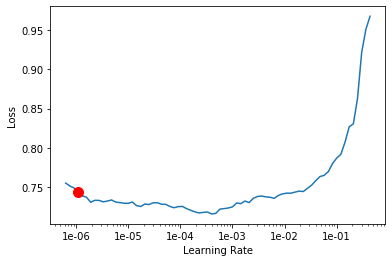

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
lr = learn.recorder.min_grad_lr

In [24]:
learn.fit_one_cycle(2, max_lr=1e-6) 

epoch,train_loss,valid_loss,accuracy,time
0,0.731935,0.755300,0.553333,01:35
1,0.721923,0.753188,0.560000,01:46


In [25]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
preds = np.array(preds)[:,1]
accuracy_score(y, preds>0.5), roc_auc_score(y, preds>0.5)

(0.56, 0.5387205387205387)

In [43]:
from hyperopt import fmin, tpe, hp, Trials
import fastai
from fastprogress import force_console_behavior
import fastprogress

space = {'p2': hp.quniform('p2',0,.8,.1),
    'emb_drop': hp.quniform('emb_drop',0,.8,.1),
    'l1': hp.quniform('l1',500,1500,100),
         }

# suppress widgets
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
fastprogress.fastprogress.WRITER_FN = str

def objective(x):
    #get params from hyperopt
    p2 = x['p2']
    p1 = p2/10
    emb_drop = x['emb_drop']
    l1=int(x['l1'])
    l2 = int(l1/2)
    # lr = x['lr']
    
    # freeze seeds
    import random
    import torch
    seed = 13
    random.seed(seed)    #python
    np.random.seed(seed) #numpy
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    # get to work
    learn = tabular_learner(data, layers=[l1,l2],ps=[p1,p2], wd=1e-1, emb_drop=emb_drop)
    learn.fit_one_cycle(2, max_lr=1e-2)
    preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
    preds = np.array(preds)
    score = -roc_auc_score(y, preds[:,1]>0.5)
    
    return {'loss': score, 'status':'ok'}

trials = Trials()

best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)
best

100%|██████████| 50/50 [2:03:05<00:00, 134.55s/it, best loss: -0.5845117845117844] 


{'emb_drop': 0.6000000000000001, 'l1': 1000.0, 'p2': 0.30000000000000004}